In [1]:
import numpy as np
import pandas
import matplotlib.pyplot as plt
from scipy.stats import halfnorm
from scipy.stats import sem
# from scipy.statistics import stdev
import os
import seaborn as sns
import sys
sns.set()

C_ATC = [0 ,10 ,20,40 ,60 ,80 ,100 ,150 ,250 ,500 ,750,1000]

In [2]:
def fold_change(lkns, el, gama,c, K=1):
    
    pref= 1/lkns -1
    numeratorfc = 1+np.exp(-el-gama)*((c/K)**2)
    denomenatorfc = 1+np.exp(-el)*((c/K)**2)
    
    FC = 1/(1+pref*numeratorfc/denomenatorfc)
    return FC

### Fig. 3B

In [30]:
# the inferred 1000 posterior samples (el,gama,sigma) for each mutant, taken from 1 million MC samples
with open('Inferred_Post_Samples.txt','r') as f: 
    alllines=f.readlines()
Post_Samples=[]
for each in alllines[2::2]:
    Temp=[]
    for eac in each[2:-3].split('], ['): 
        temp=[float(ea) for ea in eac.split(',')]
        Temp.append(temp)
    Post_Samples.append(Temp[1:1001])
print(np.shape(Post_Samples))

(23, 1000, 3)


In [21]:
# experimental leakiness of each mutant and the corresponding sem
with open('leak_info.txt','r') as g:
    alllines=g.readlines()[0][2:-2]
    
temp_leakraw, Leakns_read =alllines.split('], ['), []
for each in temp_leakraw:
    tplkr, templ =each.split(','), []
    for eac in tplkr: templ.append(float(eac))
    Leakns_read.append(templ)
print(np.shape(Leakns_read))

(23, 2)


In [23]:
leakWT=Leakns_read[-1][0]

def check_parainfer(lkinfo, paraminfered,percentile):
    perc=1-percentile
    
    ed= -np.log(1/lkinfo[0]-1) + np.log(1/leakWT-1)
    edl=-np.log(1/(lkinfo[0]-lkinfo[1])-1) + np.log(1/leakWT-1)
    edh=-np.log(1/(lkinfo[0]+lkinfo[1])-1) + np.log(1/leakWT-1)
        
    parainfered_el, parainfered_gama, parainfered_sigma = [],[],[]

    for i in range(len(paraminfered)):
        parainfered_el.append(paraminfered[i][0])
        parainfered_gama.append(paraminfered[i][1])
        parainfered_sigma.append(paraminfered[i][2])

    parainfered_el=np.sort(parainfered_el)
    parainfered_gama=np.sort(parainfered_gama)
    parainfered_sigma=np.sort(parainfered_sigma)
    
    median2 = [ [ed,edl,edh],
               [np.median(parainfered_el),parainfered_el[round(len(paraminfered)*perc/2)],parainfered_el[-round(len(paraminfered)*perc/2)]],
               [np.median(parainfered_gama),parainfered_gama[round(len(paraminfered)*perc/2)],parainfered_gama[-round(len(paraminfered)*perc/2)]],
             [np.median(parainfered_sigma),parainfered_sigma[round(len(paraminfered)*perc/2)],parainfered_sigma[-round(len(paraminfered)*perc/2)]]]
    return median2

In [31]:
Parameters = []
for i in range(23): 
    Parameters.append(check_parainfer(Leakns_read[i], Post_Samples[i], 0.95))
print(np.shape(Parameters))

(23, 4, 3)


In [26]:
Post_mutname=[ 'Y132A', 'C203V', 'D53H', 'PIF',
               'R49G',  'P105M', 'G143M','E150Y', 'Q32A-E147G',   
              
               'G102D+\nK98Q', 'G102D+\nL146A', 'G102D+\nT26A', 'G102D+\nHQQ', 'G102D+\nY42M-I57N', 
              
               'Y132A_G102D_T26A', 'Y132A_PIF', 'Y132A_R49G', 'Y132A_C203V',
               'C203V_D53H',       'C203V_R49G','C203V_PIF',  'C203V_G102D_L146A', 'WT']
print(len(Post_mutname))

23


In [32]:
bar_para1, mutname1=[],['WT', 'Y132A','C203V','Q32A-E147G', 'R49G', 'D53H','P105M', 'G143M','E150Y','PIF', 
                        'G102D+\nT26A','G102D+\nY42M-I57N','G102D+\nK98Q', 'G102D+\nL146A'  ,'G102D+\nHQQ' ]
for each in mutname1:
    for i in range(23):
        if Post_mutname[i]==each: bar_para1.append(Parameters[i])
print(np.shape(bar_para1), np.shape(mutname1))

(15, 4, 3) (15,)


In [33]:
def param_plot(paras,mutnames,figname=None,rota=0, wdth=0.25,ylo=0,ytickss=np.arange(0,14.1,2)):
    new_barplot = plt.figure(figsize=(2*(len(paras)+1),6))
    parafreq = new_barplot.add_subplot(111)
    x=np.arange(1,len(paras)+1)
    edval, elval, gammaval =[],[],[]
    edvallow, edvalhigh, elvallow, elvalhigh, gammavallow, gammavalhigh=[],[],[],[],[],[]
    for eachp in (paras):
        edval.append(eachp[0][0])
        elval.append(eachp[1][0])
        gammaval.append(eachp[2][0])
        
        edvallow.append(eachp[0][1])
        edvalhigh.append(eachp[0][2])
        elvallow.append(eachp[1][1])
        elvalhigh.append(eachp[1][2])
        gammavallow.append(eachp[2][1])
        gammavalhigh.append(eachp[2][2])
    edval,edvallow,edvalhigh = np.asarray(edval),np.asarray(edvallow),np.asarray(edvalhigh)
    elval,elvallow,elvalhigh = np.asarray(elval),np.asarray(elvallow),np.asarray(elvalhigh)
    gammaval,gammavallow,gammavalhigh = np.asarray(gammaval),np.asarray(gammavallow),np.asarray(gammavalhigh)
    
    Ced, Cel, Cgama = '#029386','steelblue','#FF4500'
    
    width=wdth
    rects1 = parafreq.bar(x, edval, width, color=Ced,alpha=0.7,yerr=[(edval-edvallow),(edvalhigh-edval)],capsize=3)
    rects2 = parafreq.bar(x+width, elval, width, color=Cel,alpha=0.9,yerr=[(elval-elvallow),(elvalhigh-elval)],capsize=3)
    rects3 = parafreq.bar(x+2*width, gammaval, width,color=Cgama,yerr=[(gammaval-gammavallow),(gammavalhigh-gammaval)],capsize=3)
    
    parafreq.set_ylabel('Parameter Value ($k_BT$)', fontsize = 28, fontweight = 'bold')
    parafreq.set_xticks(x+1*width)
    
    parafreq.set_xticklabels(mutnames,rotation=rota)
    parafreq.tick_params(labelsize=25) # make ticks bigger
    parafreq.set_ylim([ylo-0.5, 14])
    parafreq.set_xlim([0.7, len(paras)+0.8])
    parafreq.legend((rects1, rects2, rects3), ('$\epsilon_D$', '$\epsilon_L$', '$\gamma$'),ncol=3,frameon=False, fontsize = 28, loc='upper left' )
    #number on top of the bars
    nmft=25
    for i in range(1, len(edval)+1):
        parafreq.text(i-0.17, edval[i-1] + 0.6, str(round(edval[i-1],1)), color='black', fontsize=nmft)
        parafreq.text(i+0.09, elval[i-1] + 0.6, str(round(elval[i-1],1)), color='black', fontsize=nmft)
        if gammaval[i-1]<0:
            parafreq.text(i+0.38, gammaval[i-1] - 1.1, str(round(gammaval[i-1],1)), color='black', fontsize=nmft)
        else:
            parafreq.text(i+0.38, gammaval[i-1] + 0.6, str(round(gammaval[i-1],1)), color='black', fontsize=nmft)
    parafreq.axhline(round(edval[0],1), color=Ced, linestyle='--', linewidth=1)
    parafreq.axhline(round(elval[0],1), color=Cel, linestyle='--', linewidth=1)
    parafreq.axhline(round(gammaval[0],1), color=Cgama, linestyle='--', linewidth=1)
    parafreq.set_yticks(ytickss)

#     if figname: new_barplot.savefig(figname,dpi=300,bbox_inches='tight',pad_inches=0.01)

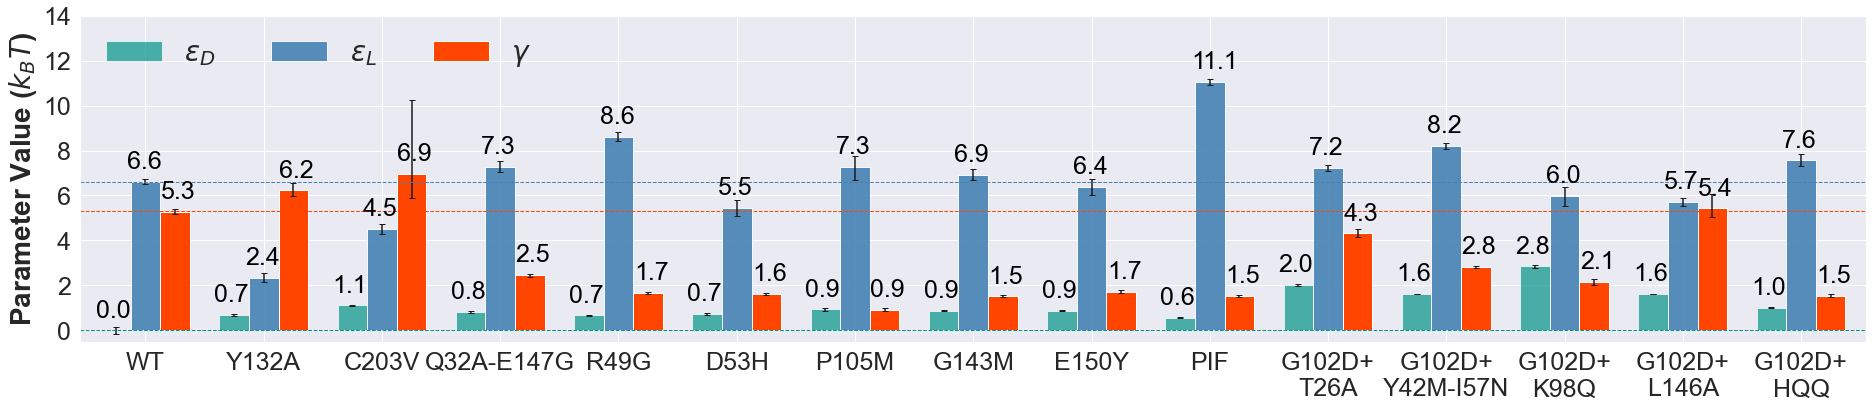

In [35]:
param_plot(bar_para1,mutname1)

### Fig. S12B

In [45]:
Post_mutname=[ 'Y132A', 'C203V', 'D53H', 'PIF',
               'R49G',  'P105M', 'G143M','E150Y', 'Q32A-E147G',   
              
               'G102D+\nK98Q', 'G102D+\nL146A', 'G102D+\nT26A', 'G102D+\nHQQ', 'G102D+\nY42M-I57N', 
              
               'Y132A-G102D-T26A', 'Y132A-PIF', 'Y132A-R49G', 'Y132A-C203V',
               'C203V-D53H',       'C203V-R49G','C203V-PIF',  'C203V-G102D-L146A', 'WT']
print(len(Post_mutname))

23


In [46]:
para_WT = Parameters[-1]
print(np.shape(para_WT))

(4, 3)


In [48]:
# for comb let's do '
combnames=[['Y132A-G102D-T26A','Y132A','G102D+\nT26A'], ['Y132A-R49G','Y132A','R49G'],
           ['Y132A-PIF','Y132A','PIF'],['Y132A-C203V','Y132A','C203V'],['C203V-R49G','C203V','R49G'],
           ['C203V-D53H','C203V','D53H'],  ['C203V-G102D-L146A','C203V','G102D+\nL146A'], 
           ['C203V-PIF','C203V','PIF']]
combnames_xu=[]
for each in combnames:
    temp=[]
    for eac in each:
        for i in range(23):
            if Post_mutname[i]==eac: temp.append(i)
    combnames_xu.append(temp)
print(np.shape(combnames), np.shape(combnames_xu))

(8, 3) (8, 3)


In [49]:
def adp(postsample1, postsample2, WT_el=6.6, WT_gama=5.3):
    elcomb, gamacomb= [], []
    for each in postsample1:
        for eac in postsample2:
            elcomb.append(each[0]+eac[0]-WT_el)
            gamacomb.append(each[1]+eac[1]-WT_gama)
    elcomb=np.sort(elcomb)
    gamacomb=np.sort(gamacomb)
    
    return [[np.median(elcomb), elcomb[int(1000000*0.025)], elcomb[int(-1000000*0.025)]],
            [np.median(gamacomb), gamacomb[int(1000000*0.025)], gamacomb[int(-1000000*0.025)]]]

In [50]:
def param_pred_plot(parasxu,mutnames,figname=None,rota=-8, wdth=0.25,ylo=-4,ytickss=np.arange(-4,14.1,2)):
    new_barplot = plt.figure(figsize=(3*(len(parasxu)+2),8))
    parafreq = new_barplot.add_subplot(111)
    x=np.arange(1,2.5*len(parasxu)+1,2.5)
    
    edval, elval, gammaval =[],[],[]
    edvallow, edvalhigh, elvallow, elvalhigh, gammavallow, gammavalhigh=[],[],[],[],[],[]
    
    edvalp, elvalp, gammavalp =[],[],[]
    edvallowp, edvalhighp, elvallowp, elvalhighp, gammavallowp, gammavalhighp=[],[],[],[],[],[]
        
    for each in parasxu:
        ab,a,b =each[0], each[1],each[2]
        edval.append(Parameters[ab][0][0])
        edvallow.append(Parameters[ab][0][1])
        edvalhigh.append(Parameters[ab][0][2])
        
        elval.append(Parameters[ab][1][0])
        elvallow.append(Parameters[ab][1][1])
        elvalhigh.append(Parameters[ab][1][2])
        
        gammaval.append(Parameters[ab][2][0])
        gammavallow.append(Parameters[ab][2][1])
        gammavalhigh.append(Parameters[ab][2][2])
        ''''''
        
        edvalp.append(Parameters[a][0][0]+Parameters[b][0][0])
        edvallowp.append(Parameters[a][0][0]+Parameters[b][0][0])
        edvalhighp.append(Parameters[a][0][0]+Parameters[b][0][0])
        
        elvalp.append(adp(Post_Samples[a], Post_Samples[b])[0][0])
        elvallowp.append(adp(Post_Samples[a], Post_Samples[b])[0][1])
        elvalhighp.append(adp(Post_Samples[a], Post_Samples[b])[0][2])
        
        gammavalp.append(adp(Post_Samples[a], Post_Samples[b])[1][0])
        gammavallowp.append(adp(Post_Samples[a], Post_Samples[b])[1][1])
        gammavalhighp.append(adp(Post_Samples[a], Post_Samples[b])[1][2])
    
    edval,edvallow,edvalhigh = np.asarray(edval),np.asarray(edvallow),np.asarray(edvalhigh)
    elval,elvallow,elvalhigh = np.asarray(elval),np.asarray(elvallow),np.asarray(elvalhigh)
    gammaval,gammavallow,gammavalhigh = np.asarray(gammaval),np.asarray(gammavallow),np.asarray(gammavalhigh)
    edvalp,edvallowp,edvalhighp = np.asarray(edvalp),np.asarray(edvallowp),np.asarray(edvalhighp)
    elvalp,elvallowp,elvalhighp = np.asarray(elvalp),np.asarray(elvallowp),np.asarray(elvalhighp)
    gammavalp,gammavallowp,gammavalhighp = np.asarray(gammavalp),np.asarray(gammavallowp),np.asarray(gammavalhighp)
    
    width=wdth
    widd = 1.3*wdth
#     width = 0.2
    xwt=np.asarray([-0.4])
    edvalwt, edvallowwt, edvalhighwt = [para_WT[0][0]],[para_WT[0][1]],[para_WT[0][2]]
    elvalwt, elvallowwt, elvalhighwt = [para_WT[1][0]-0],[para_WT[1][1]-0],[para_WT[1][2]-0]
    gammavalwt, gammavallowwt, gammavalhighwt = [para_WT[2][0]-0],[para_WT[2][1]-0],[para_WT[2][2]-0]
    
    edvalwt,edvallowwt,edvalhighwt = np.asarray(edvalwt),np.asarray(edvallowwt),np.asarray(edvalhighwt)
    elvalwt,elvallowwt,elvalhighwt = np.asarray(elvalwt),np.asarray(elvallowwt),np.asarray(elvalhighwt)
    gammavalwt,gammavallowwt,gammavalhighwt = np.asarray(gammavalwt),np.asarray(gammavallowwt),np.asarray(gammavalhighwt)
    
    Ced, Cel, Cgama = '#029386','steelblue','#FF4500'
    
    rectswt1 = parafreq.bar(xwt, edvalwt, width, color=Ced,yerr=[(edvalwt-edvallowwt),(edvalhighwt-edvalwt)],capsize=3)
    rectswt2 = parafreq.bar(xwt+width, elvalwt, width, color=Cel,yerr=[(elvalwt-elvallowwt),(elvalhighwt-elvalwt)],capsize=3)
    rectswt3 = parafreq.bar(xwt+2*width, gammavalwt, width,color=Cgama,yerr=[(gammavalwt-gammavallowwt),(gammavalhighwt-gammavalwt)],capsize=3)
    


    rects1 = parafreq.bar(x, edval, width, color=Ced,yerr=[(edval-edvallow),(edvalhigh-edval)],capsize=3)
    rects2 = parafreq.bar(x+widd, edvalp, width, color=Ced,alpha=0.7,yerr=[(edvalp-edvallowp),(edvalhighp-edvalp)],capsize=3)
    
    rects3 = parafreq.bar(x+2*widd, elval, width, color=Cel,yerr=[(elval-elvallow),(elvalhigh-elval)],capsize=3)
    rects4 = parafreq.bar(x+3*widd, elvalp, width, color=Cel,alpha=0.7,yerr=[(elvalp-elvallowp),(elvalhighp-elvalp)],capsize=3)
    
    rects5 = parafreq.bar(x+4*widd, gammaval, width,color=Cgama,yerr=[(gammaval-gammavallow),(gammavalhigh-gammaval)],capsize=3)
    rects6 = parafreq.bar(x+5*widd, gammavalp, width,color=Cgama,alpha=0.7,yerr=[(gammavalp-gammavallowp),(gammavalhighp-gammavalp)],capsize=3)
    
    
    parafreq.set_ylabel('parameter value ($k_BT$)', fontsize = 28, fontweight = 'bold')
    parafreq.set_xticks([-0.2]+list(x+3*width))
    
    parafreq.set_xticklabels(['WT']+list(mutnames),rotation=rota)
    parafreq.tick_params(labelsize=25) # make ticks bigger
    parafreq.set_ylim([ylo, 14])
    parafreq.set_xlim([-0.7, 2.5*len(parasxu)+0.5])
    parafreq.legend((rects1, rects3, rects5), ('$\epsilon_D$', '$\epsilon_L$', '$\gamma$'),ncol=3,frameon=False, fontsize = 28, loc='upper left' )
    #number on top of the bars
    nmft=22
    parafreq.text(-0.5-0., edvalwt[0] + 0.6, str(round(0,1)), color='black', fontsize=nmft)
    parafreq.text(-0.5+0.12, elvalwt[0] + 0.6, str(round(para_WT[1][0],1)), color='black', fontsize=nmft)
    parafreq.text(-0.5+0.5, gammavalwt[0] + 0.6, str(round(para_WT[2][0],1)), color='black', fontsize=nmft)
    
    for i in range(1, len(edval)+1,1):
        parafreq.text((i-1)*2.5+0.75, edval[i-1] + 0.3, str(round(edval[i-1],1)), color='black', fontsize=nmft)
        parafreq.text((i-1)*2.5+1.12, edvalp[i-1] + 0.3, str(round(edvalp[i-1],1)), color='black', fontsize=nmft)
        parafreq.text((i-1)*2.5+1.4, elval[i-1] + 0.65, str(round(elval[i-1],1)), color='black', fontsize=nmft)
        parafreq.text((i-1)*2.5+1.8, elvalp[i-1] + 0.65, str(round(elvalp[i-1],1)), color='black', fontsize=nmft)
        if gammaval[i-1]<0:
            parafreq.text((i-1)*2.5+2.3, gammaval[i-1] - 0.9, str(round(gammaval[i-1],1)), color='black', fontsize=nmft)
            parafreq.text((i-1)*2.5+2.5, gammavalp[i-1] + 0.6, str(round(gammavalp[i-1],1)), color='black', fontsize=nmft)
        else:
            parafreq.text((i-1)*2.5+2.1, gammaval[i-1] + 0.6, str(round(gammaval[i-1],1)), color='black', fontsize=nmft)
            parafreq.text((i-1)*2.5+2.5, gammavalp[i-1] + 0.6, str(round(gammavalp[i-1],1)), color='black', fontsize=nmft)
    parafreq.axhline(round(para_WT[0][0],1), color=Ced, linestyle='--', linewidth=1)
    parafreq.axhline(round(para_WT[1][0],1), color=Cel, linestyle='--', linewidth=1)
    parafreq.axhline(round(para_WT[2][0],1), color=Cgama, linestyle='--', linewidth=1)
    parafreq.set_yticks(ytickss)
    plt.show()
#     if figname: new_barplot.savefig(figname,dpi=300,bbox_inches='tight',pad_inches=0.01)        

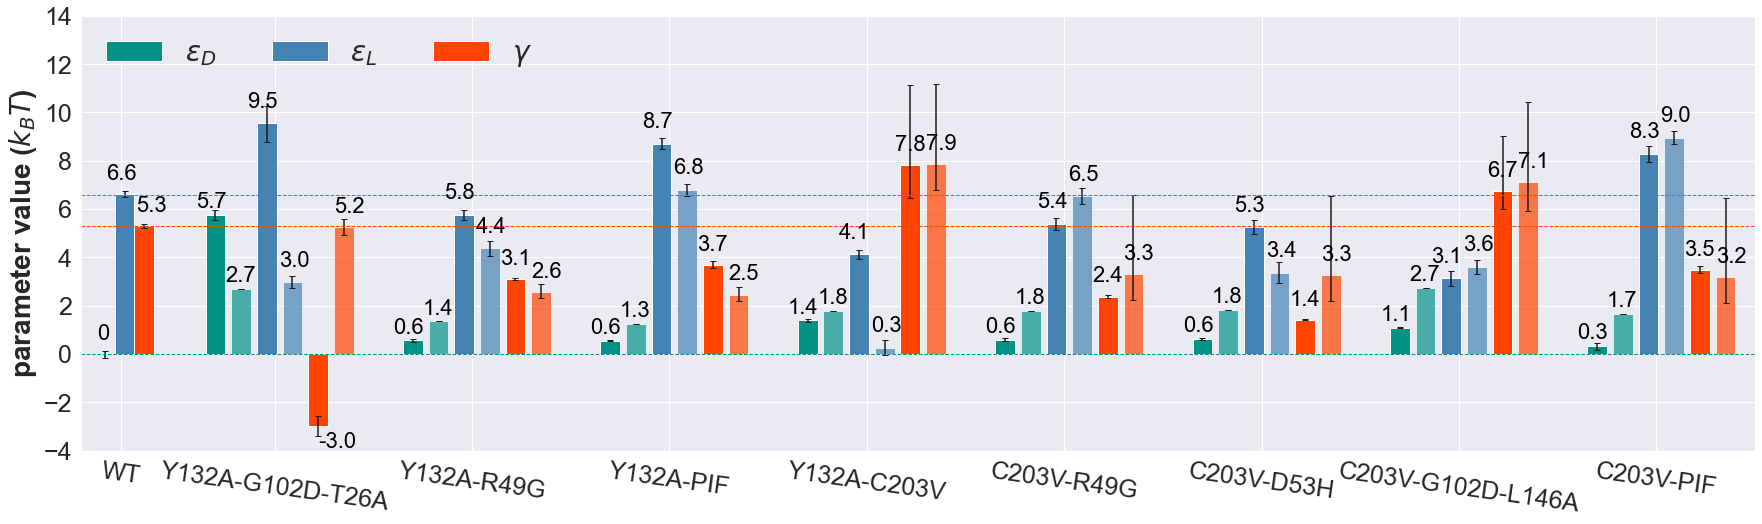

In [51]:
param_pred_plot(combnames_xu, np.asarray(combnames)[:,0])